#### The purpose of this notebooks is to test whether the single trial beta maps produce a similar maps as the SPM univariate analysis

Method:
* 1) convert .nii to .npy : scripts/step10_nilearn/glm/cue-high_GT_cue-low/glm_numpify_ttest.py
* 2) average .npy per subject (session and run concatenated): scripts/step10_nilearn/glm/cue-high_GT_cue-low/numpy_ttest_cue.py
* 3) plot the end product here.

In [11]:
import numpy as np
import os, glob, re, pathlib
import statsmodels 
from statsmodels.stats import multitest
import scipy
import nilearn
from scipy import stats
from nilearn.image import resample_to_img, math_img, new_img_like
from nilearn import image, plotting
import argparse
import matplotlib.pyplot as plt
import neuromaps
from surfplot import Plot
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps


In [7]:
def plot_surf_box(surfaces, surf_lh, surf_rh, title):

    lh, rh = surfaces['inflated']

    p = Plot(surf_lh=lh, surf_rh=rh) #, size=(600, 600)) #, layout='column')
    p.add_layer({'left': surf_lh, 
                'right': surf_rh}, #stimP_rh}, 
                cmap=nilearn_cmaps['cold_hot'],#cm.seismic, 
                cbar=True)

    kws = dict(location='right', draw_border=False, aspect=10, shrink=.2,
            decimals=0, pad=0)
    fig = p.build(cbar_kws=kws)
    fig.axes[0].set_title(title, pad=-3)

    fig.show()

# task-pain

In [2]:
# create mask from canlab mask. Use sample single trial as target shape/affine
imgfname = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz'
ref_img = image.load_img(imgfname)

mask = image.load_img('/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii')
mask_img = nilearn.masking.compute_epi_mask(mask, target_affine = ref_img.affine, target_shape = ref_img.shape)

nifti_masker = nilearn.maskers.NiftiMasker(mask_img= mask_img,
                                           smoothing_fwhm=6,
                            target_affine = ref_img.affine, target_shape = ref_img.shape, 
                    memory="nilearn_cache", memory_level=1)

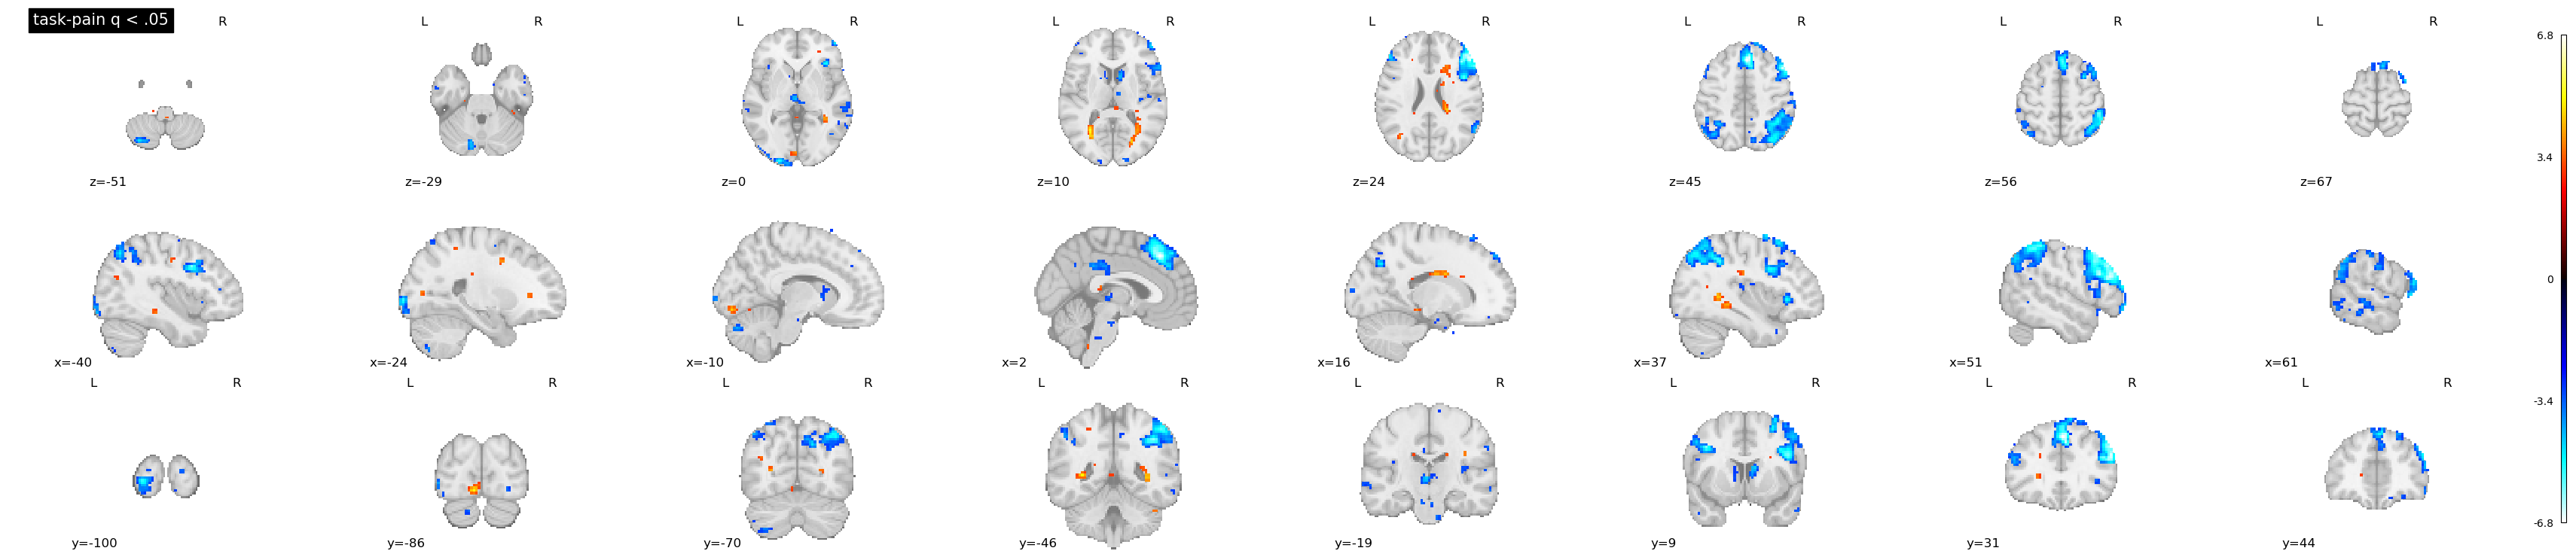

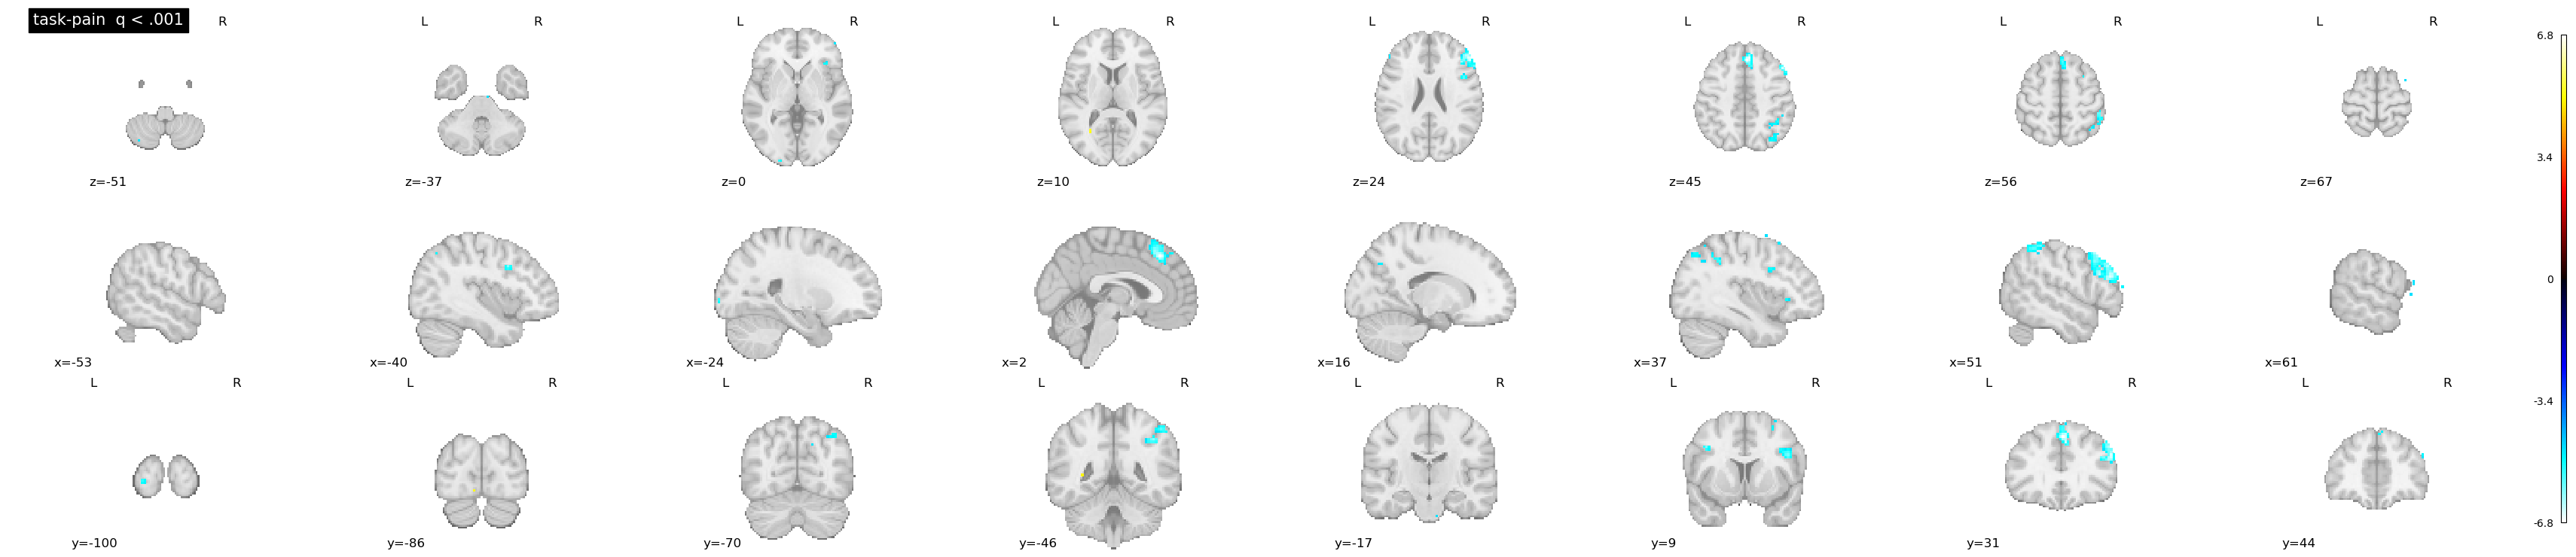

In [19]:
# load group data
taskname = 'pain'
beta_dir =  '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy'
suballLv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-pain_event-stimulus_cuetype-low.npy"))
suballHv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-pain_event-stimulus_cuetype-high.npy"))

# apply mask to each average numpy (shape: subjects x voxels)
        
x,y,z=ref_img.shape
Hp = []
Lp = []
for index in range(suballHv.shape[0]):

    Hp.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballHv[index].reshape(x,y,z)))
    )
    Lp.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballLv[index].reshape(x,y,z)))
    )

fmri_masked_stimhighp = np.vstack(Hp)
fmri_masked_stimlowp = np.vstack(Lp)

tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhighp, fmri_masked_stimlowp, axis = 0, nan_policy = 'propagate',alternative='two-sided' )
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')

result_mapp = np.zeros(fmri_masked_stimhighp.shape[1])
result_mapp[qvalues < .05] = tvalues[qvalues < .05]
con_tmapp = nifti_masker.inverse_transform(result_mapp)

result_map_001p = np.zeros(fmri_masked_stimhighp.shape[1])
result_map_001p[qvalues < .001] = tvalues[qvalues < .001]
con_tmap_001p = nifti_masker.inverse_transform(result_map_001p)

plotting.plot_stat_map(con_tmapp,  display_mode = 'mosaic', title = 'task-pain q < .05', cut_coords = 8)
plotting.plot_stat_map(con_tmap_001p,  display_mode = 'mosaic', title = 'task-pain  q < .001', cut_coords = 8)


# save
unthres_tmap = nifti_masker.inverse_transform(tvalues)
unthres_tmap.to_filename(f'singletrial-tmap_task-{taskname}_con-HcuegtLcue_p-unthres.nii.gz')
con_tmapp.to_filename(f'singletrial-tmap_task-{taskname}_con-HcuegtLcue_q-05.nii.gz')
con_tmap_001p.to_filename(f'singletrial-tmap_task-{taskname}_con-HcuegtLcue_q-001.nii.gz')

In [4]:
print(f"min: {np.min(con_tmapp.get_fdata())}")
print(f"max: {np.max(con_tmapp.get_fdata())}")
print(f"mean: {np.mean(con_tmapp.get_fdata())}")

min: -6.7877168279233135
max: 5.283440419936456
mean: -0.03871606552255417


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_99889/4058096332.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


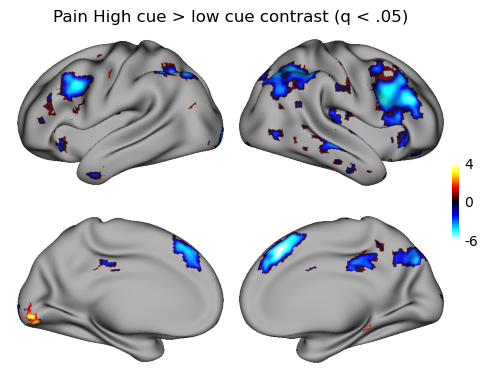

: 

In [20]:
taskname = 'pain'
stimHgtL_P = neuromaps.transforms.mni152_to_fslr(f'singletrial-tmap_task-{taskname}_con-HcuegtLcue_q-05.nii.gz', fslr_density='32k', method='linear')
stimP_lh = stimHgtL_P[0].darrays[0].data
stimP_rh = stimHgtL_P[1].darrays[0].data

surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
plot_surf_box(surfaces, 
          surf_lh=stimP_lh, 
          surf_rh= stimP_rh, 
          title=f'{taskname.title()} High cue > low cue contrast (q < .05)')

# task-vicarious

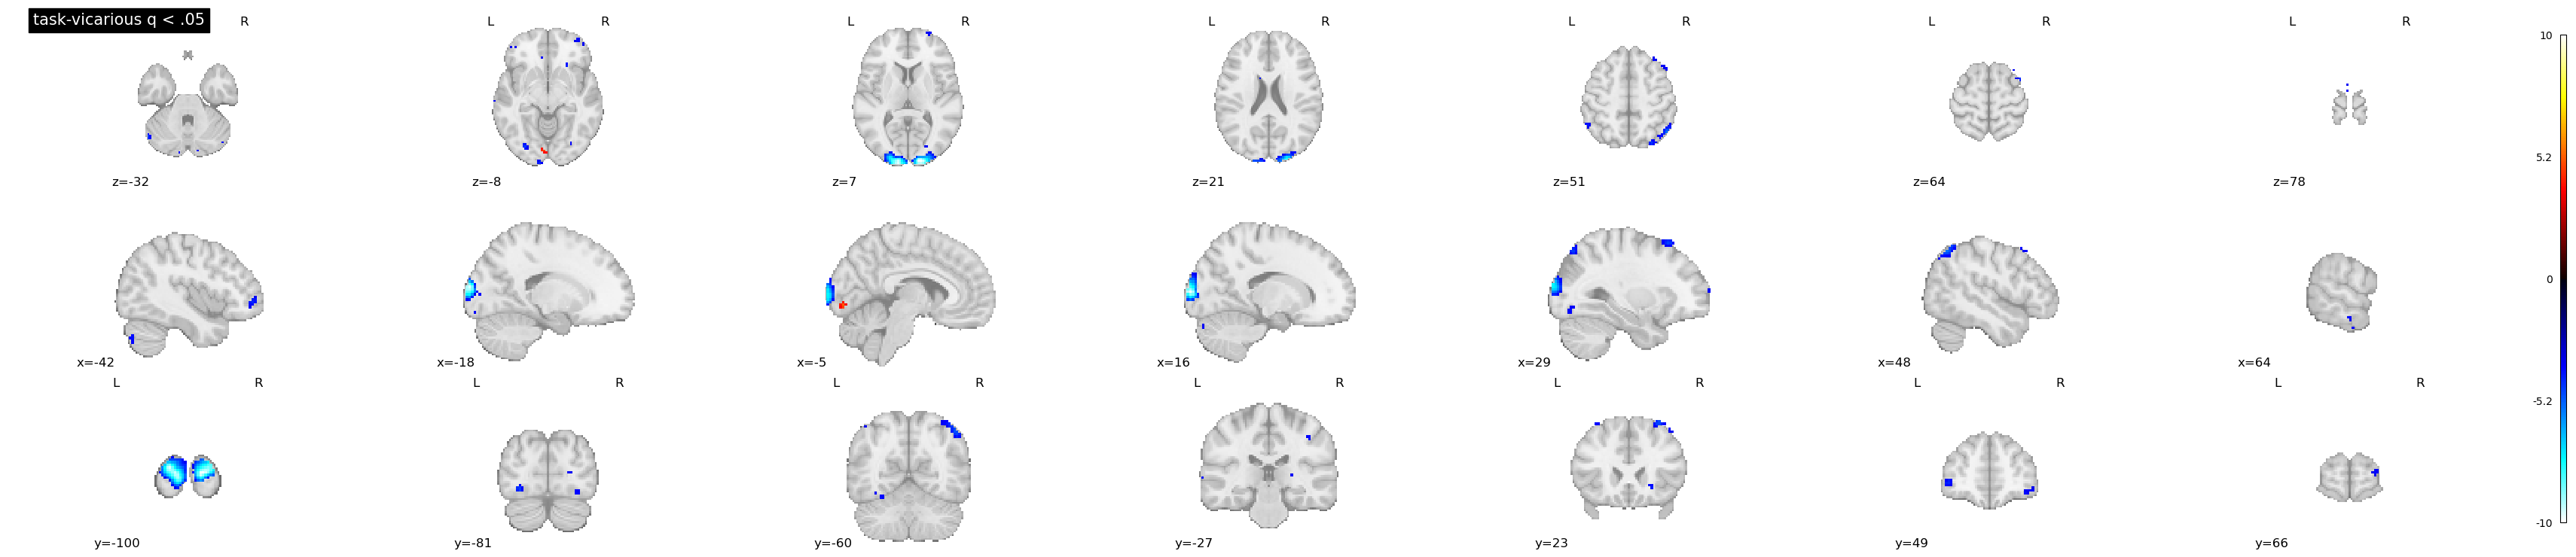

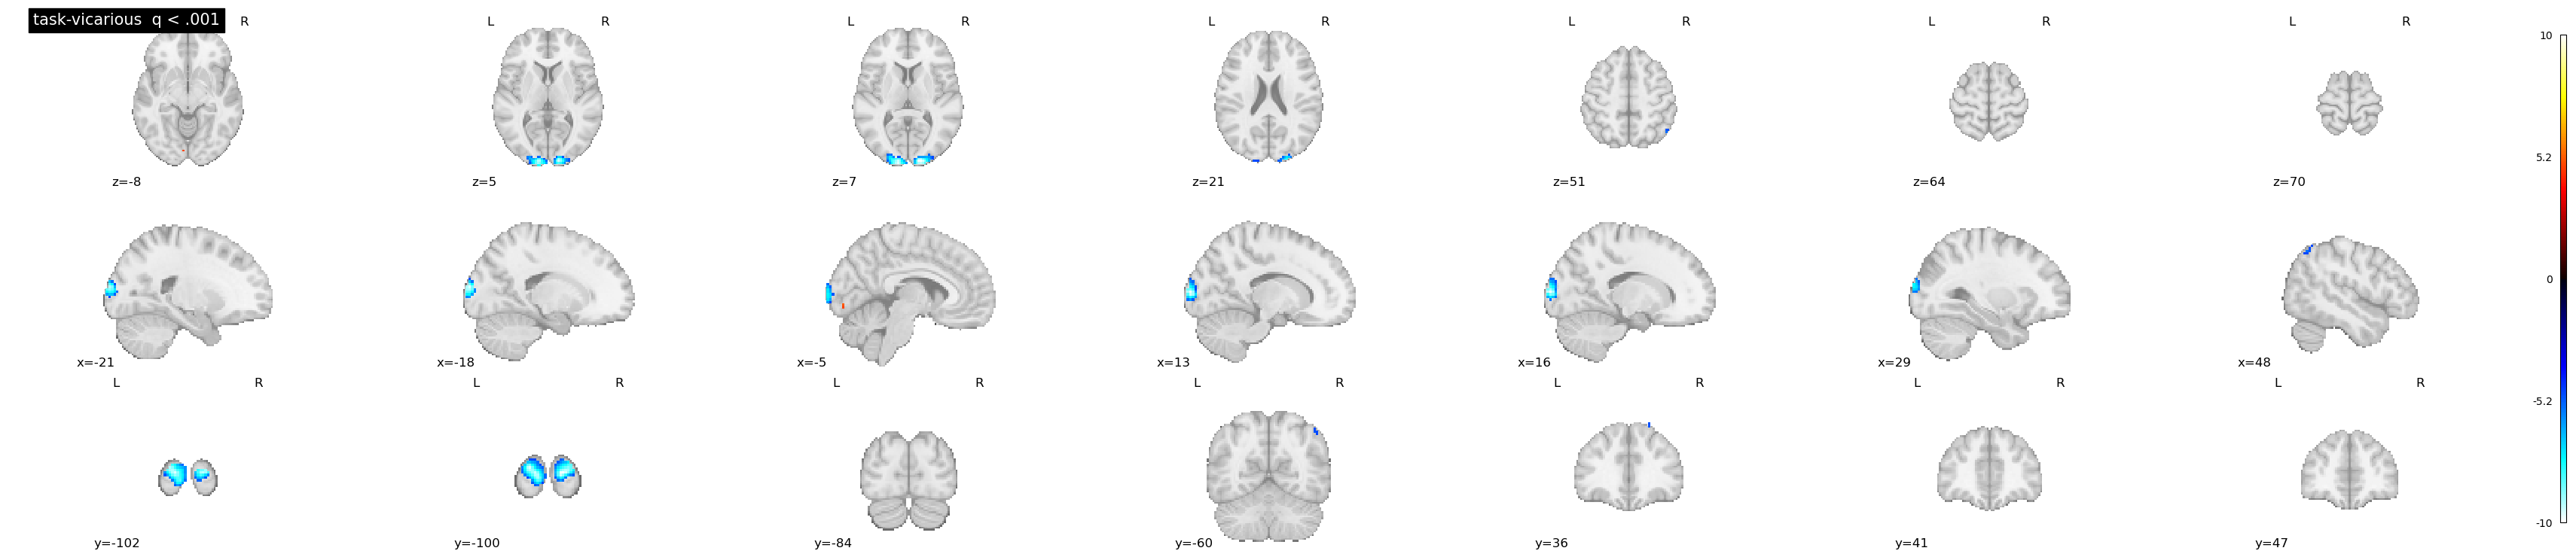

In [14]:
# load group data
taskname = 'vicarious'
beta_dir =  '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy'
suballLv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-vicarious_event-stimulus_cuetype-low.npy"))
suballHv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-vicarious_event-stimulus_cuetype-high.npy"))

# apply mask to each average numpy (shape: subjects x voxels)
        
x,y,z=ref_img.shape
Hv = []
Lv = []
for index in range(suballHv.shape[0]):

    Hv.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballHv[index].reshape(x,y,z)))
    )
    Lv.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballLv[index].reshape(x,y,z)))
    )

fmri_masked_stimhighv = np.vstack(Hv)
fmri_masked_stimlowv = np.vstack(Lv)

tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhighv, fmri_masked_stimlowv, axis = 0, nan_policy = 'propagate',alternative='two-sided' )
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')

result_mapv = np.zeros(fmri_masked_stimhighv.shape[1])
result_mapv[qvalues < .05] = tvalues[qvalues < .05]
con_tmapv = nifti_masker.inverse_transform(result_mapv)

result_map_001v = np.zeros(fmri_masked_stimhighv.shape[1])
result_map_001v[qvalues < .001] = tvalues[qvalues < .001]
con_tmap_001v = nifti_masker.inverse_transform(result_map_001v)

plotting.plot_stat_map(con_tmapv,  display_mode = 'mosaic', title = 'task-vicarious q < .05')
plotting.plot_stat_map(con_tmap_001v,  display_mode = 'mosaic', title = 'task-vicarious  q < .001')


# save
unthres_tmap = nifti_masker.inverse_transform(tvalues)
unthres_tmap.to_filename(f'singletrial-tmap_task-{taskname}_con-HcuegtLcue_p-unthres.nii.gz')
con_tmapv.to_filename(f'singletrial-tmap_task-{taskname}_con-HcuegtLcue_q-05.nii.gz')
con_tmap_001v.to_filename(f'singletrial-tmap_task-{taskname}_con-HcuegtLcue_q-001.nii.gz')

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_99889/4058096332.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


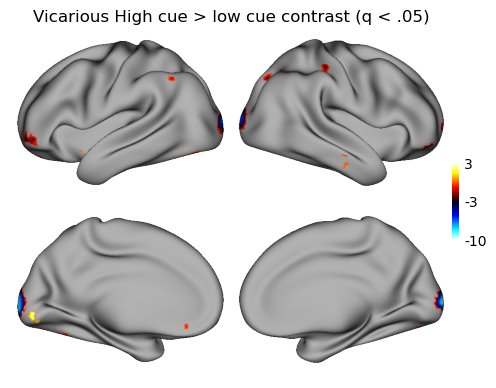

In [16]:
taskname = 'vicarious'
stimHgtL_P = neuromaps.transforms.mni152_to_fslr(f'singletrial-tmap_task-{taskname}_con-HcuegtLcue_q-05.nii.gz', fslr_density='32k', method='linear')
stimP_lh = stimHgtL_P[0].darrays[0].data
stimP_rh = stimHgtL_P[1].darrays[0].data

surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
plot_surf_box(surfaces, 
          surf_lh=stimP_lh, 
          surf_rh= stimP_rh, 
          title=f'{taskname.title()} High cue > low cue contrast (q < .05)')

# task-cognitive

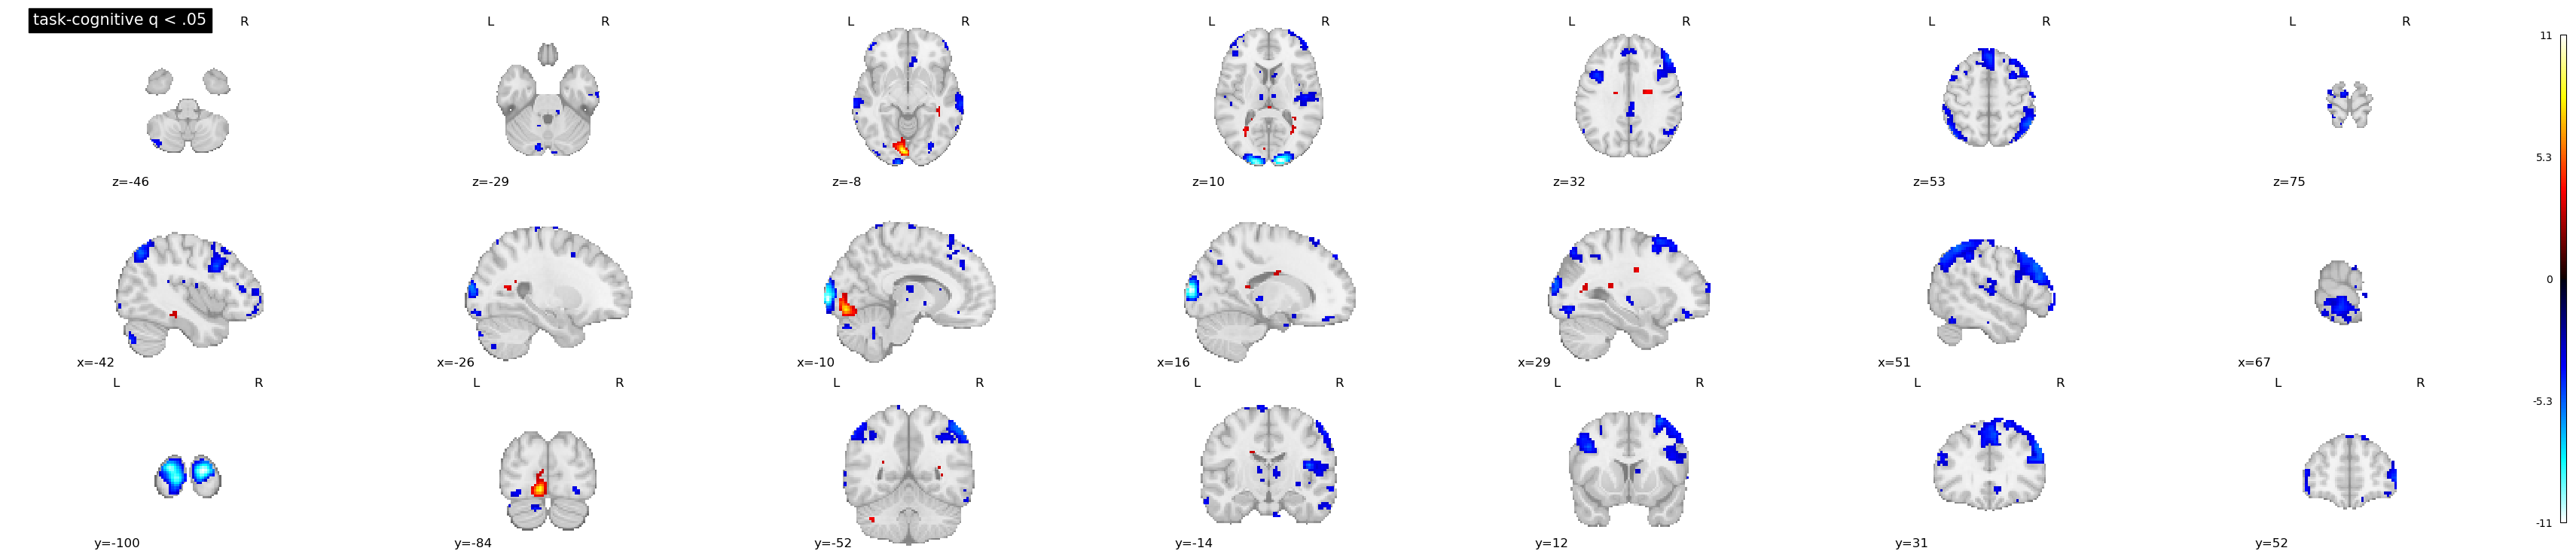

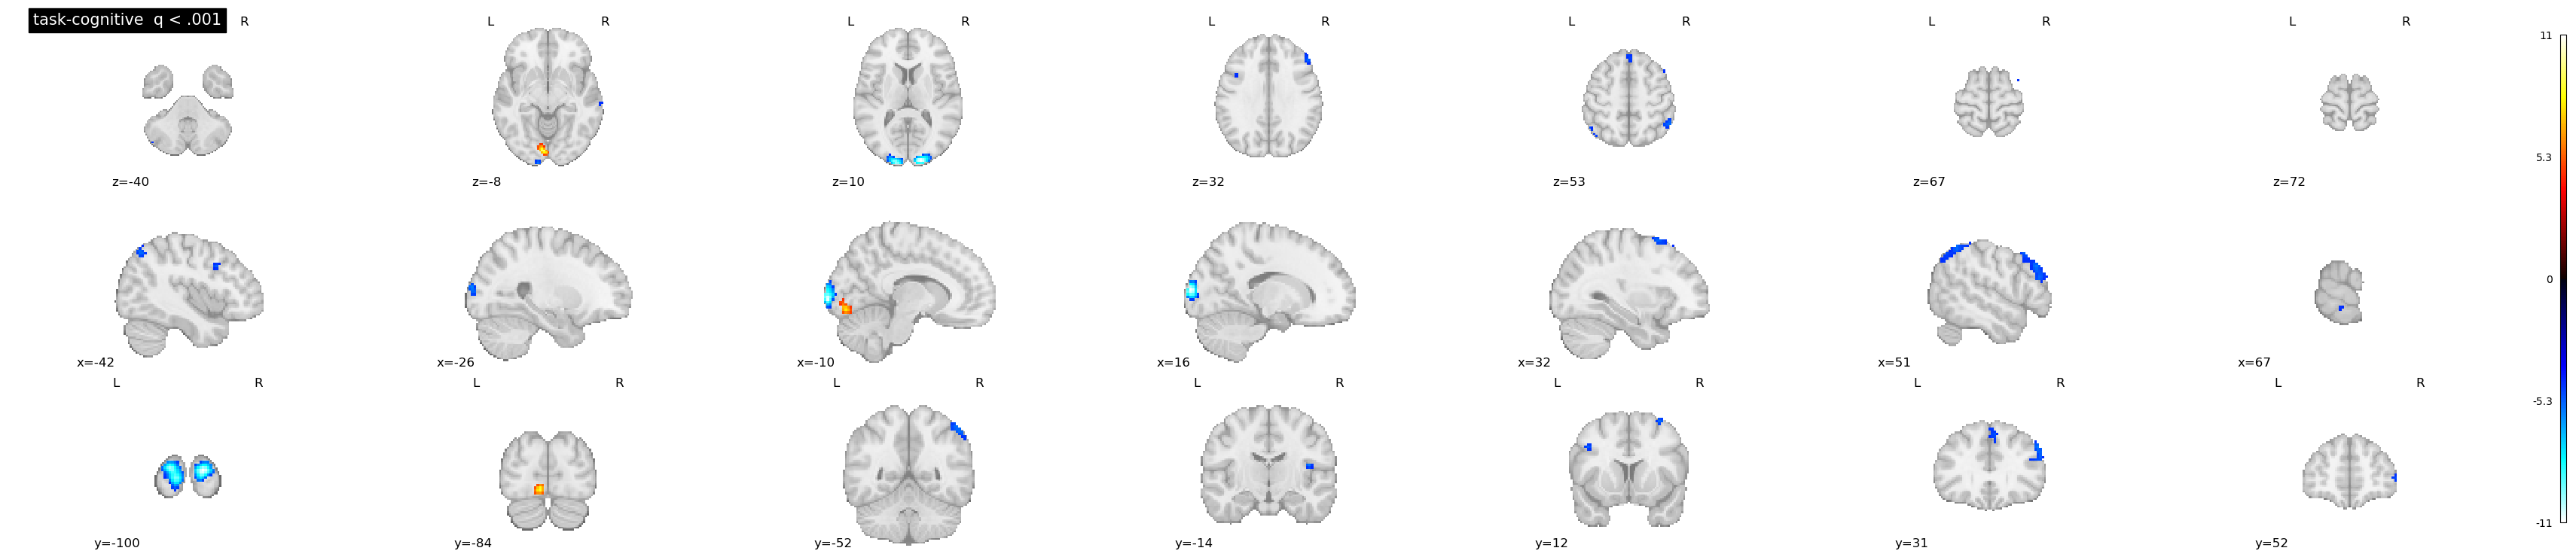

In [17]:
# load group data
taskname = 'cognitive'
beta_dir =  '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy'
suballLv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-cognitive_event-stimulus_cuetype-low.npy"))
suballHv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_task-cognitive_event-stimulus_cuetype-high.npy"))

# apply mask to each average numpy (shape: subjects x voxels)
        
x,y,z=ref_img.shape
Hc = []
Lc = []
for index in range(suballHv.shape[0]):

    Hc.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballHv[index].reshape(x,y,z)))
    )
    Lc.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballLv[index].reshape(x,y,z)))
    )

fmri_masked_stimhighc = np.vstack(Hc)
fmri_masked_stimlowc = np.vstack(Lc)

tvalues, pvalues = scipy.stats.ttest_rel(fmri_masked_stimhighc, fmri_masked_stimlowc, 
                                         axis = 0, nan_policy = 'propagate',alternative='two-sided' )
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')

result_mapc = np.zeros(fmri_masked_stimhighc.shape[1])
result_mapc[qvalues < .05] = tvalues[qvalues < .05]
con_tmapc = nifti_masker.inverse_transform(result_mapc)

result_map_001c = np.zeros(fmri_masked_stimhighc.shape[1])
result_map_001c[qvalues < .001] = tvalues[qvalues < .001]
con_tmap_001c = nifti_masker.inverse_transform(result_map_001c)

plotting.plot_stat_map(con_tmapc,  display_mode = 'mosaic', title = 'task-cognitive q < .05')
plotting.plot_stat_map(con_tmap_001c,  display_mode = 'mosaic', title = 'task-cognitive  q < .001')


# save
unthres_tmap = nifti_masker.inverse_transform(tvalues)
unthres_tmap.to_filename(f'singletrial-tmap_task-{taskname}_con-HcuegtLcue_p-unthres.nii.gz')
con_tmapc.to_filename(f'singletrial-tmap_task-{taskname}_con-HcuegtLcue_q-05.nii.gz')
con_tmap_001c.to_filename(f'singletrial-tmap_task-{taskname}_con-HcuegtLcue_q-001.nii.gz')

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_99889/4058096332.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


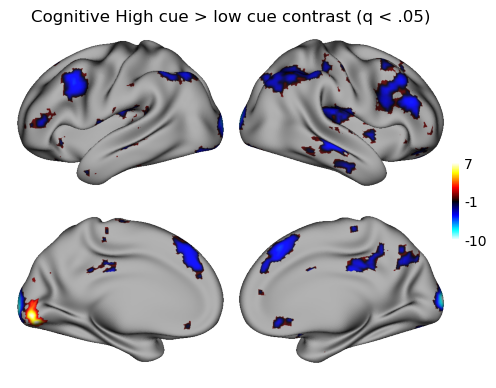

In [18]:

stimHgtL_P = neuromaps.transforms.mni152_to_fslr(f'singletrial-tmap_task-{taskname}_con-HcuegtLcue_q-05.nii.gz', fslr_density='32k', method='linear')
stimP_lh = stimHgtL_P[0].darrays[0].data
stimP_rh = stimHgtL_P[1].darrays[0].data

surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
plot_surf_box(surfaces, 
          surf_lh=stimP_lh, 
          surf_rh= stimP_rh, 
          title=f'{taskname.title()} High cue > low cue contrast (q < .05)')